In [73]:
import os
# full path to 30 FPS video
seq_id = '2024_08_15__19_55_49'
rgb_video_path = f"/media/zipa/Data/egowalk_30FPS/egowalk_cosmos_processed/video/rgb/{seq_id}__rgb.mp4"
dpt_video_path = f"/media/zipa/Data/egowalk_30FPS/egowalk_cosmos_processed/video/depth/{seq_id}__depth.mkv"
assert(os.path.exists(rgb_video_path))
assert(os.path.exists(dpt_video_path))

In [90]:
import numpy as np
import cv2
import json

def calc_initial_frame(src_video_path, h, m, s):
    fps = int(cv2.VideoCapture(src_video_path).get(cv2.CAP_PROP_FPS))
    return (h * 60 * 60 + m * 60 + s ) * fps, fps

def load_video_fragment(src_video_path, initial_frame, frames_count, frames_step, drop_chans=False):
    frames = []
    rdr = cv2.VideoCapture(src_video_path)
    # print(fps := rdr.get(cv2.CAP_PROP_FPS))
    i_frame = 0
    while True:
        have_read, frame_data = rdr.read()
        if not have_read:
            break
        if i_frame >= initial_frame and (i_frame - initial_frame) % frames_step == 0:
            # print(f"Pushing frame {i_frame}")
            if drop_chans:
                frame_data = frame_data[:, :, 0]
            frames.append(frame_data)
            if len(frames) == frames_count:
                break
        i_frame += 1
    assert(len(frames) == frames_count)
    return frames

def save_video(output_path, frames, fps):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frames[0].shape[1], frames[0].shape[0]))
    for frame in frames:
        if len(frame.shape) == 2:
            frame = np.stack([frame, frame, frame], axis=2)
        out.write(frame)
    out.release()

def save_experiment(rgb, dpt, fps, prompt, is_full_prompt, experiment_folder, relative_root='../'):
    rgb_name = f'{experiment_folder}/rgb.mp4'
    dpt_name = f'{experiment_folder}/depth.mp4'
    json_name = f'{experiment_folder}/spec.json'
    shell_name = f'{experiment_folder}/runme.sh'

    os.makedirs(os.path.join(relative_root, experiment_folder), 0o777, True)
    save_video(os.path.join(relative_root, rgb_name), rgb, fps)
    save_video(os.path.join(relative_root, dpt_name), dpt, fps)

    with open(os.path.join(relative_root, json_name), 'w') as fp:
        json.dump({"prompt": prompt, "input_video_path": rgb_name,
                    "depth": {"input_control": dpt_name, "control_weight": 1.0},
                    "edge": {"control_weight": 1.0},
                    "vis": {"control_weight": 1.0},
                    "seg": {"control_weight": 1.0}
                    }, fp)

    # generate script to call it from shell
    shell_script_full_path = os.path.join(relative_root, shell_name)
    output_string = """
    export CUDA_VISIBLE_DEVICES="${CUDA_VISIBLE_DEVICES:=0}"
    export CHECKPOINT_DIR="${CHECKPOINT_DIR:=./checkpoints}"
    export NUM_GPU="${NUM_GPU:=1}"
    """

    output_string += f"PYTHONPATH=$(pwd) torchrun --nproc_per_node=$NUM_GPU --nnodes=1 --node_rank=0 cosmos_transfer1/diffusion/inference/transfer.py \
        --checkpoint_dir $CHECKPOINT_DIR \
        --video_save_folder {experiment_folder}/output \
        --controlnet_specs {json_name} \
        --offload_text_encoder_model \
        --offload_guardrail_models \
        --offload_prompt_upsampler \
        --num_gpus $NUM_GPU"
    if not is_full_prompt:
        output_string += "--upsample_prompt" + '\n'
    with open(shell_script_full_path, 'w') as fp:
        print(output_string, file=fp)

    os.chmod(shell_script_full_path, 0o777)

In [61]:
starting_frame, video_fps = calc_initial_frame(rgb_video_path, h=0, m=2, s=0)
rgb = load_video_fragment(rgb_video_path, starting_frame, 4 * 30, frames_step=1, drop_chans=False)
dpt = load_video_fragment(dpt_video_path, starting_frame, 4 * 30, frames_step=1, drop_chans=True)

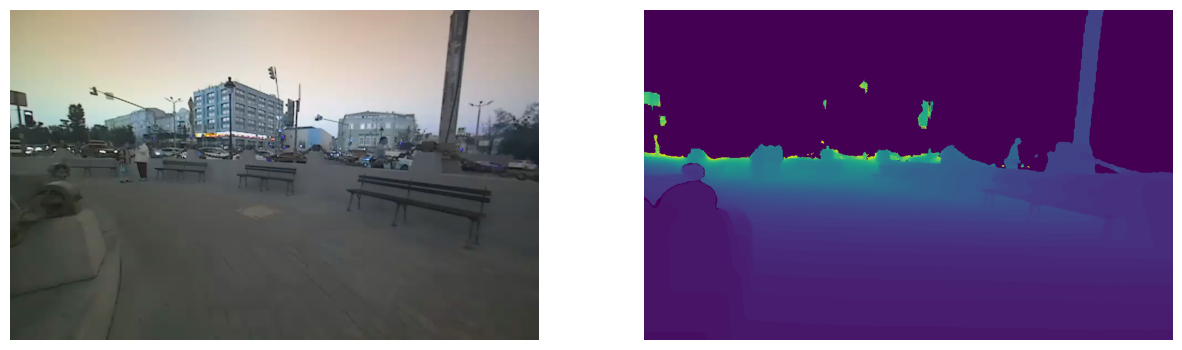

In [62]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
for i_axis, data in enumerate([rgb[0], dpt[0]]):
    axes[i_axis].imshow(data)
    axes[i_axis].axis('off')


In [ ]:
# full code for generating the experiment
fps = 30
# prompt = "The video captures a series of frames showing a street view from a pedastrian. \
#     The street is lined with buildings of various colors, including red, yellow, and white. \
#     There are no visible pedestrians, and the traffic is minimal with a few cars and a motorcycle passing by. \
#     The sky is partly cloudy with blue patches, and the overall atmosphere appears calm."
prompt = "moving through city street. buildings around, few people ahead."

is_full_prompt = False
start_time_in_minutes = 2 # minutes
fragment_length_in_seconds = 4 # seconds
    
starting_frame, _ = calc_initial_frame(rgb_video_path, h=0, m=start_time_in_minutes, s=0)

experiment_folder = f'{seq_id}_{starting_frame}_{fps}_{fragment_length_in_seconds}_{"full" if is_full_prompt else "short"}' 

rgb = load_video_fragment(rgb_video_path, starting_frame, fragment_length_in_seconds * fps, frames_step=1, drop_chans=False)
dpt = load_video_fragment(dpt_video_path, starting_frame, fragment_length_in_seconds * fps, frames_step=1, drop_chans=True)
save_experiment(rgb, dpt, fps, prompt, is_full_prompt, experiment_folder)

In [ ]:
# generate several experiments
prompt = "moving through city street. buildings around, few people ahead."
is_full_prompt = False
downsampling_resolution = 1
fps_range = [4, 30]
duration_range = [2, 4, 8]
start_range = [0, 1, 2, 3]

for fps in fps_range:
    for fragment_length_in_seconds in duration_range:
        for start_time_in_minutes in start_range:
            starting_frame, _ = calc_initial_frame(rgb_video_path, h=0, m=start_time_in_minutes, s=0)
            experiment_folder = f'{seq_id}_{starting_frame}_{fps}_{fragment_length_in_seconds}_{"full" if is_full_prompt else "short"}' 
            if fps == 30:
                frames_step = 1
            elif fps == 4:
                frames_step = 7
            rgb = load_video_fragment(rgb_video_path, starting_frame, fragment_length_in_seconds * fps, frames_step=frames_step, drop_chans=False)
            dpt = load_video_fragment(dpt_video_path, starting_frame, fragment_length_in_seconds * fps, frames_step=frames_step, drop_chans=True)
            if downsampling_resolution > 1:
                for i_frame in range(len(rgb)):
                    rgb[i_frame] = rgb[i_frame][::downsampling_resolution, ::downsampling_resolution, :]
                    dpt[i_frame] = dpt[i_frame][::downsampling_resolution, ::downsampling_resolution]
            save_experiment(rgb, dpt, fps, prompt, is_full_prompt, experiment_folder)